In [23]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.tools.visualization import plot_histogram

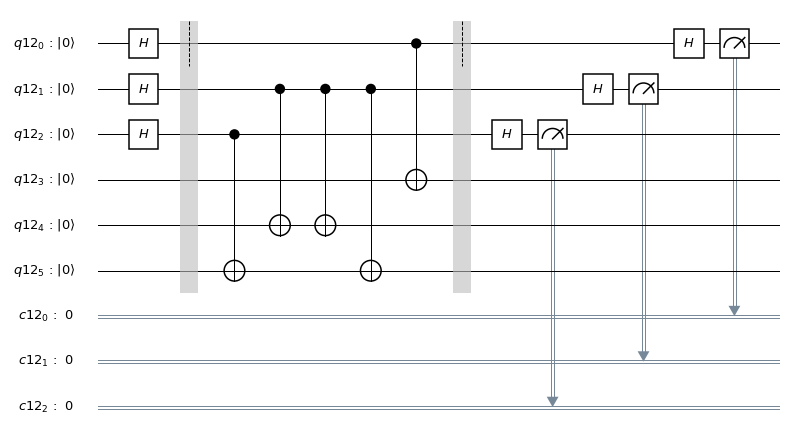

In [30]:
n = 3

qr = QuantumRegister(n*2) # 4 qubit register
cr = ClassicalRegister(n) # 1 classical register
circ = QuantumCircuit(qr, cr) # Quantum Circuit on q

for i in range(0, n):
    circ.h(qr[i])

circ.barrier()

for i in range(0, n):
    circ.cx(qr[i], qr[n+i])


for i in range(0, n):
    secret += str(random.randint(0, 10000)%2)

s = "011" #temp val

#xor s to register 2 (temp).
for i, c in enumerate(s):
    if c == '1':
        circ.cx(qr[1], qr[n+i])

# TO DO, rest of black box. maybe

circ.barrier()

for i in range(0, n):
    circ.h(qr[i])

for i in range(n):
    circ.measure(qr[i], cr[i])

circ.draw(output='mpl')

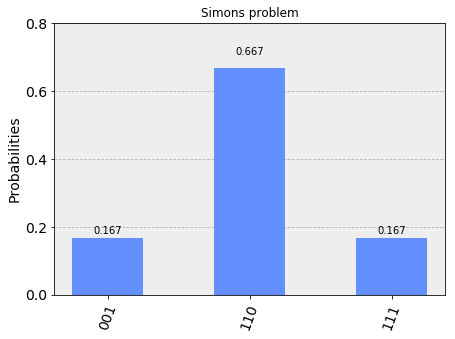

In [34]:
simulator = Aer.get_backend('qasm_simulator')

result = execute(circ, simulator, shots=n*2).result()
count = result.get_counts(circ)
plot_histogram(counts, title='Simons problem')

In [32]:
count

{'110': 247, '000': 249, '001': 285, '111': 243}

In [8]:
secret = ""
for i in range(0, n):
    secret += str(random.randint(0, 10000)%2) #binary string

print(secret)

01
